In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from scipy import sparse

In [87]:
df_train = pd.read_csv("datasets/cat-in-the-dat-ii/train.csv")

In [88]:
df_train

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,599995,0.0,1.0,0.0,T,N,Red,Polygon,Axolotl,India,...,015c63324,3.0,Novice,Freezing,a,R,GZ,5.0,NaN,0
599996,599996,1.0,0.0,0.0,T,Y,Blue,Polygon,Dog,Costa Rica,...,a02ae6a63,2.0,Novice,Boiling Hot,n,N,sf,NaN,3.0,0
599997,599997,0.0,0.0,0.0,F,Y,Red,Circle,Axolotl,Russia,...,40f9610c1,2.0,Contributor,Freezing,n,H,MV,7.0,5.0,0
599998,599998,1.0,1.0,0.0,F,Y,NaN,Polygon,Axolotl,NaN,...,c1a8374a0,1.0,Master,Warm,m,X,Ey,1.0,5.0,0


### check the target distribution

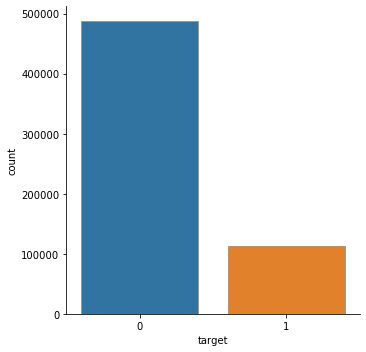

In [15]:
sns.catplot(x='target', kind="count", data=df_train, edgecolor="0.6")

This looks like unbalanced distribution so we cannot use accuracy as evaluation metric. We need to use precision, recall, F1 , AUC in this case. We will just use AUC since it combines both precision and recall

### look at feature ord_2

In [26]:
assert df_train.ord_2.value_counts().sum() == len(df_train), print("length does not match- possibility of NaNs in feature")

length does not match- possibility of NaNs in feature


AssertionError: None

- since sklearn does not handle NaN, use pandas to handle NaNs

In [29]:
df_train.loc[:,"ord_2"] = df_train.ord_2.fillna("NONE") #create a new category

In [30]:
 df_train.ord_2.value_counts()

Freezing       142726
Warm           124239
Cold            97822
Boiling Hot     84790
Hot             67508
Lava Hot        64840
NONE            18075
Name: ord_2, dtype: int64

In [31]:
assert df_train.ord_2.value_counts().sum() == len(df_train), print("length does not match- possibility of NaNs in feature")

- use LabelEncoding to convert this feature into integer

In [33]:
labelenc = preprocessing.LabelEncoder()
df_train.loc[:,"ord_2"] = labelenc.fit_transform(df_train.ord_2.values)

In [34]:
 df_train.ord_2.value_counts()

2    142726
6    124239
1     97822
0     84790
3     67508
4     64840
5     18075
Name: ord_2, dtype: int64

See NONE has been mapped to label 5

`NOTE` **LabelEncoding can be used with all kind of trees based models but not with LinearModels, SVM, neural network based models since they assume input data is normalized**

- how many samples do we have where ord_2 == "Boiling Hot"

In [106]:
# reload since we have earlier converted ord_2 to LabelEncodoing
df_train = pd.read_csv("datasets/cat-in-the-dat-ii/train.csv")

In [66]:
df_train.loc[:,"ord_2"] = df_train.ord_2.fillna("NONE")

In [67]:
df_train.groupby(["ord_2"])["id"].count()

ord_2
Boiling Hot     84790
Cold            97822
Freezing       142726
Hot             67508
Lava Hot        64840
NONE            18075
Warm           124239
Name: id, dtype: int64

In [68]:
df_train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


### Another way of handling categorical data is to replace categories by count

In [73]:
df_train.groupby(["ord_2"])["id"].transform("count")

0          67508
1         124239
2         142726
3          64840
4          97822
           ...  
599995    142726
599996     84790
599997    142726
599998    124239
599999     84790
Name: id, Length: 600000, dtype: int64

In [72]:
df_train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [76]:
df_train.groupby(["ord_2", "ord_1"])["id"].count()

ord_2        ord_1      
Boiling Hot  Contributor    15634
             Expert         19477
             Grandmaster    13623
             Master         10800
             Novice         22718
Cold         Contributor    17734
             Expert         22956
             Grandmaster    15464
             Master         12364
             Novice         26271
Freezing     Contributor    26082
             Expert         33249
             Grandmaster    22818
             Master         18035
             Novice         38233
Hot          Contributor    12428
             Expert         15792
             Grandmaster    10805
             Master          8594
             Novice         17850
Lava Hot     Contributor    11919
             Expert         15078
             Grandmaster    10363
             Master          8209
             Novice         17373
NONE         Contributor     3250
             Expert          4225
             Grandmaster     2894
             Master    

### creating new  features from categorical features

In [90]:
df_train["new_features"] = (df_train.ord_1.astype(str) + "_" + df_train.ord_2.astype(str))

In [91]:
df_train

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target,new_features
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0,Contributor_Hot
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0,Grandmaster_Warm
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0,nan_Freezing
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0,Novice_Lava Hot
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0,Grandmaster_Cold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,599995,0.0,1.0,0.0,T,N,Red,Polygon,Axolotl,India,...,3.0,Novice,Freezing,a,R,GZ,5.0,NaN,0,Novice_Freezing
599996,599996,1.0,0.0,0.0,T,Y,Blue,Polygon,Dog,Costa Rica,...,2.0,Novice,Boiling Hot,n,N,sf,NaN,3.0,0,Novice_Boiling Hot
599997,599997,0.0,0.0,0.0,F,Y,Red,Circle,Axolotl,Russia,...,2.0,Contributor,Freezing,n,H,MV,7.0,5.0,0,Contributor_Freezing
599998,599998,1.0,1.0,0.0,F,Y,NaN,Polygon,Axolotl,NaN,...,1.0,Master,Warm,m,X,Ey,1.0,5.0,0,Master_Warm


In [92]:
df_train.loc[:,"new_features_2"] = (df_train.ord_1.astype(str) + "_" + df_train.ord_2.astype(str))

In [93]:
df_train

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target,new_features,new_features_2
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,Contributor,Hot,c,U,Pw,6.0,3.0,0,Contributor_Hot,Contributor_Hot
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,Grandmaster,Warm,e,X,pE,7.0,7.0,0,Grandmaster_Warm,Grandmaster_Warm
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,NaN,Freezing,n,P,eN,5.0,9.0,0,nan_Freezing,nan_Freezing
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,Novice,Lava Hot,a,C,NaN,3.0,3.0,0,Novice_Lava Hot,Novice_Lava Hot
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,Grandmaster,Cold,h,C,OZ,5.0,12.0,0,Grandmaster_Cold,Grandmaster_Cold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,599995,0.0,1.0,0.0,T,N,Red,Polygon,Axolotl,India,...,Novice,Freezing,a,R,GZ,5.0,NaN,0,Novice_Freezing,Novice_Freezing
599996,599996,1.0,0.0,0.0,T,Y,Blue,Polygon,Dog,Costa Rica,...,Novice,Boiling Hot,n,N,sf,NaN,3.0,0,Novice_Boiling Hot,Novice_Boiling Hot
599997,599997,0.0,0.0,0.0,F,Y,Red,Circle,Axolotl,Russia,...,Contributor,Freezing,n,H,MV,7.0,5.0,0,Contributor_Freezing,Contributor_Freezing
599998,599998,1.0,1.0,0.0,F,Y,NaN,Polygon,Axolotl,NaN,...,Master,Warm,m,X,Ey,1.0,5.0,0,Master_Warm,Master_Warm


In [107]:
df_train.loc[:,"ord_4"] = df_train.ord_4.fillna("NONE")

In [108]:
df_train["ord_4"].value_counts()

N       39978
P       37890
Y       36657
A       36633
R       33045
U       32897
M       32504
X       32347
C       32112
H       31189
Q       30145
T       29723
O       25610
B       25212
E       21871
K       21676
I       19805
NONE    17930
D       17284
F       16721
W        8268
Z        5790
S        4595
G        3404
V        3107
J        1950
L        1657
Name: ord_4, dtype: int64

In [109]:
df_train.loc[df_train["ord_4"].value_counts()[df_train["ord_4"]].values < 2000, "ord_4"] = "RARE"
df_train["ord_4"].value_counts()

N       39978
P       37890
Y       36657
A       36633
R       33045
U       32897
M       32504
X       32347
C       32112
H       31189
Q       30145
T       29723
O       25610
B       25212
E       21871
K       21676
I       19805
NONE    17930
D       17284
F       16721
W        8268
Z        5790
S        4595
RARE     3607
G        3404
V        3107
Name: ord_4, dtype: int64